Projet : Accident de la route
==============

## Etape 3 : Modélisation

### Import des données

In [3]:
# import des librairies
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.display.max_info_columns

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lazypredict.supervised import LazyClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix,classification_report, f1_score

import warnings
warnings.filterwarnings('ignore')

In [4]:
# import du dataset
df = pd.read_csv("dataset/dataset_final.csv")
df.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3


### Modélisation

In [27]:
print("Meilleurs paramètres trouvés:", best_hp_lr)


Meilleurs paramètres trouvés: {'C': 0.0001, 'fit_intercept': True, 'max_iter': 150, 'penalty': 'l2', 'solver': 'lbfgs'}


Nombre de variables significatives selon l'Importance des coefficients : Index(['place', 'catu', 'sexe', 'trajet', 'secu1', 'locp', 'catr', 'circ',
       'nbv', 'prof', 'plan', 'surf', 'situ', 'vma', 'lum', 'atm', 'col',
       'long', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'age_group', 'weekday'],
      dtype='object')
Séparation des labels et targets : (319499, 27) (136929, 27) (319499,) (136929,)
Fitting 5 folds for each of 256 candidates, totalling 1280 fits
[CV 1/5] END C=1e-05, fit_intercept=True, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.1s
[CV 2/5] END C=1e-05, fit_intercept=True, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.1s
[CV 3/5] END C=1e-05, fit_intercept=True, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.1s
[CV 4/5] END C=1e-05, fit_intercept=True, max_iter=100, penalty=l1, solver=newton-cg;, score=nan total time=   0.1s
[CV 1/5] END C=1e-05, fit_intercept=True, ma

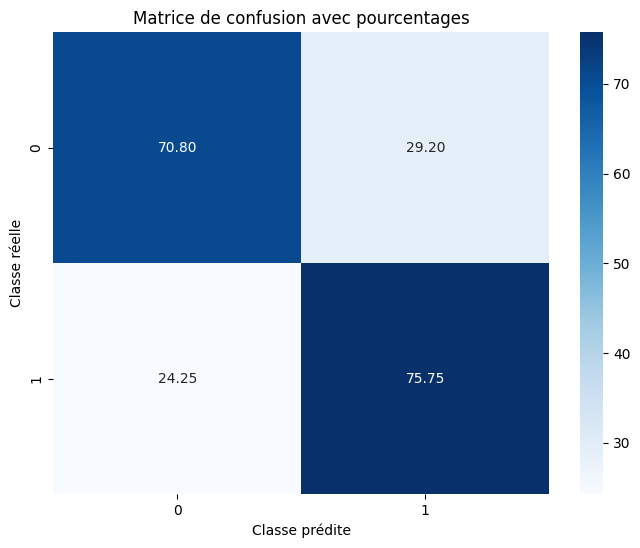

In [28]:
# Importance des coefficients
model = LogisticRegression(random_state=42)
model.fit(df.drop(["grav"], axis=1), df.grav)
importance = np.abs(model.coef_[0])
significant_features_lr = df.drop(["grav"], axis=1).columns[importance > np.percentile(importance, 20)]
print("Nombre de variables significatives selon l'Importance des coefficients :",significant_features_lr)

X = df[['place', 'catu', 'sexe', 'trajet', 'secu1', 'locp', 'catr', 'circ',
       'nbv', 'prof', 'plan', 'surf', 'situ', 'vma', 'lum', 'atm', 'col',
       'long', 'senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor',
       'age_group', 'weekday']]
y = df.grav

# séparation du dataset en un jeu train et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Séparation des labels et targets :", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# standardisation
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# modélisation
hyper_p_lr = {
    'C': [0.00001, 0.0001, 0.001, 0.001],   # Inverse de la force de régularisation
    'penalty': ['l1', 'l2'],    # Type de régularisation : 'l1' = Régu Lasso, 'l2' = Régu Ridge
    'solver': ['liblinear', 'saga', 'newton-cg', 'lbfgs'], # optimisation utilisé pour trouver les coef
    'fit_intercept' : [True, False],    # asi "true" ajoute une constante au modèle
    'max_iter' : [100,150, 200, 500]
}

gs_lr = GridSearchCV(estimator = LogisticRegression(random_state=42),
                           param_grid = hyper_p_lr,
                           cv = 5,  # Nombre de folds pour la validation croisée
                           verbose = 3, # Affiche le degré de détail des calculs
                           refit=True, # réentraine le modèle avec toutes les données
                           scoring="f1",
                           n_jobs = -1)  # Utiliser tous les coeurs du CPU

gs_lr.fit(X_train_scaled, y_train)

best_hp_lr = gs_lr.best_params_
best_score_lr = gs_lr.best_score_

print("Meilleurs paramètres trouvés:", best_hp_lr)
print("Meilleur score de validation croisée:", best_score_lr)

best_model = gs_lr.best_estimator_

y_pred_lr = best_model.predict(X_test_scaled)

cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Matrice de confusion :\n", cm_lr)

row_sums_lr = cm_lr.sum(axis = 1)
cm_percent_lr = (cm_lr.T / row_sums_lr).T * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent_lr, annot = True, fmt = ".2f", cmap = "Blues")
plt.xlabel('Classe prédite')
plt.ylabel('Classe réelle')
plt.title('Matrice de confusion avec pourcentages')
plt.show()

### Sauvegarde du modèle

In [29]:
import joblib

# Sauvegarder le modèle
joblib.dump(best_model, 'logistic_regression_model.joblib')

['logistic_regression_model.joblib']

### Analyse des résultats

In [30]:
# création d'un df pour ajouter les prédictions au dataset
df_filtered = df.iloc[:len(y_test)]  

df_filtered['pred_lr'] = y_pred_lr
df_filtered.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_lr
0,1,1,1,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,3,0,2,1,9,1,2,6,2,1
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
2,1,1,1,1,9,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,6,0,2,8,15,1,4,3,3,1
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,1
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,1


In [31]:
# création d'un df qui affiche toutes les prédictions qui ne sont pas identiques au réel
df_mismatch = df_filtered[df_filtered['grav'] != df_filtered['pred_lr']]
df_mismatch.head()

,place,catu,grav,sexe,trajet,secu1,locp,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,vma,lum,com,agg,int,atm,col,lat,long,senc,catv,obs,obsm,choc,manv,motor,age_group,h_group,weekday,pred_lr
1,1,1,0,1,5,1,-1,4,2,2,0,1,1,1,0,1,50,1,26198,2,3,1,3,44.56,4.73,1,6,0,2,2,1,1,7,6,2,1
3,1,1,0,1,4,1,0,4,2,2,0,1,1,1,0,1,50,1,25204,2,3,1,3,46.93,6.35,2,5,0,2,1,1,1,6,3,3,1
4,1,1,0,1,0,1,-1,3,-1,2,0,1,1,1,5,1,50,1,22360,2,6,1,2,48.49,-2.76,2,6,0,2,1,2,1,3,6,3,1
6,1,1,0,2,0,1,-1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,3,6,3,1
7,10,3,1,2,5,2,1,4,1,1,0,2,1,1,0,1,30,1,16102,2,3,8,6,45.69,-0.33,2,6,0,1,3,16,1,6,6,3,0
